In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def update(s, i, d):
    s_new = s + i - d
    return s_new

def buy_cost(i,t):
    if t <= 5:
        return 5*i
    else:
        return 100*i

def relu(x):
    return tf.nn.relu(x)

def penalty(x, gamma):
    return tf.where(tf.less(x, 0.), gamma * tf.abs(x), 0.)

class Subnetwork(tf.keras.Model):
    def __init__(self):
        super(Subnetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, input_shape=(-1,1), activation=None, kernel_initializer='random_normal')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(100, activation=None, kernel_initializer='random_normal')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.dense_out = tf.keras.layers.Dense(1, activation=None, kernel_initializer='random_normal')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = relu(x)
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = relu(x)
        outputs = self.dense_out(x)
        return outputs

class MyModel(tf.keras.Model):
    def __init__(self, T, smax, imax, gamma):
        super(MyModel, self).__init__()
        self.subnetworks = [Subnetwork() for _ in range(T)]
        self.T = T
        self.smax = smax
        self.imax = imax
        self.gamma = gamma

    def call(self, input, training=False):
        s = input[:,0]
        d_batch = input[:,1:]
        s = tf.reshape(s,(-1,1))
        cost = tf.zeros(s.shape)
        for t in range(self.T):
            d = d_batch[:,t]
            i = self.subnetworks[t](s, training=training)
            # i = tf.floor(i)
            # i = tf.cast(i, tf.float32)
            cost += buy_cost(i,t) + penalty(s, self.gamma) + penalty(self.smax - s, self.gamma) \
                    + penalty(i, self.gamma) + penalty(self.imax - i, self.gamma) + penalty(s + i - d, self.gamma)
            s = update(s, i, d)
            s = tf.reshape(s,(-1,1))
        return cost

2023-05-09 13:29:24.316767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(42)

T = 10 # number of subnetworks

s_0 = 50. # initial value of s_0
gamma = 1e9 # penalty parameter
smax = 100. # maximum value of s_t
imax = 30. # maximum value of i_t
learning_rate = 0.01 # learning rate for SGD
num_epochs = 1000
batch_size = 1
n_it_steps = 15000
N = int(batch_size * n_it_steps / num_epochs) # training set size

# Initial state and labels
inputs = tf.constant(s_0 * np.ones((N,1)), dtype=tf.float32)
outputs = tf.constant(np.zeros_like(inputs))

# Demand
mu = 5.0 # mean of d_t
sigma = 1.0 # standard deviation of d_t
#d_array = tf.random.normal([N,T], mean=mu, stddev=sigma)
d_array = tf.random.uniform(shape=(N,T), minval=5, maxval=35, dtype=tf.float32)
d_array = tf.floor(d_array)

# Concatenate inputs and demand
inputs = tf.concat([inputs,d_array],1)

# Instantiate model
model = MyModel(T, smax, imax, gamma)

# Define loss function and optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.MeanAbsoluteError()
metric = [tf.keras.metrics.MeanAbsoluteError()]

model.compile(optimizer=optimizer, loss=loss_function, metrics=metric)

# Train the model
history = model.fit(x=inputs, y=outputs, batch_size=batch_size, epochs=num_epochs)

2023-05-09 13:29:33.609332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
15/15 [==============================] - 12s 8ms/step - loss: 1026810707968.0000 - mean_absolute_error: 1026810707968.0000
Epoch 2/1000
15/15 [==============================] - 0s 9ms/step - loss: 1012999061504.0000 - mean_absolute_error: 1012999061504.0000
Epoch 3/1000
15/15 [==============================] - 0s 7ms/step - loss: 999287029760.0000 - mean_absolute_error: 999287029760.0000
Epoch 4/1000
15/15 [==============================] - 0s 6ms/step - loss: 985588367360.0000 - mean_absolute_error: 985588367360.0000
Epoch 5/1000
15/15 [==============================] - 0s 6ms/step - loss: 971963826176.0000 - mean_absolute_error: 971963826176.0000
Epoch 6/1000
15/15 [==============================] - 0s 6ms/step - loss: 958566301696.0000 - mean_absolute_error: 958566301696.0000
Epoch 7/1000
15/15 [==============================] - 0s 5ms/step - loss: 944998907904.0000 - mean_absolute_error: 944998907904.0000
Epoch 8/1000
15/15 [==============================] - 0s 6ms/ste

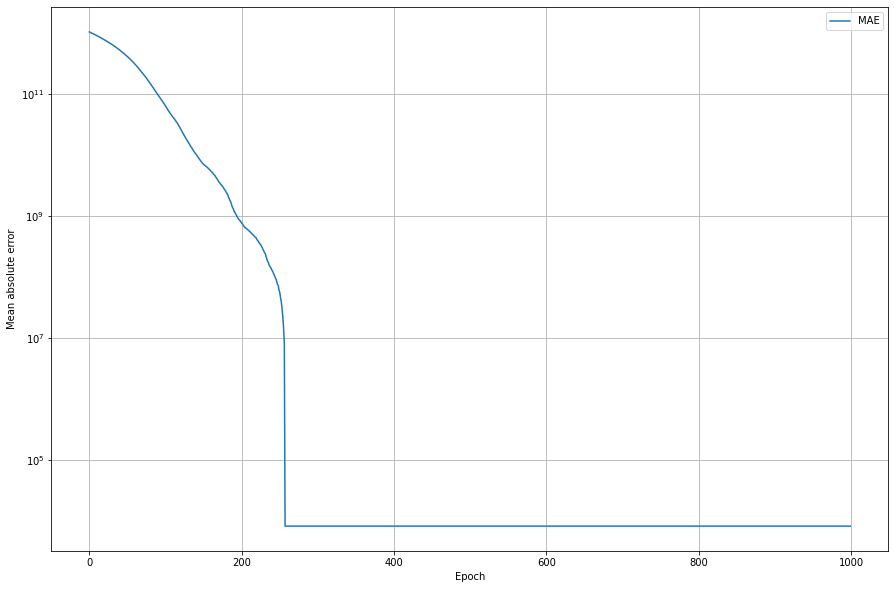

In [3]:
plt.figure('Error', figsize=(15, 10))
plt.semilogy(history.history['mean_absolute_error'], label='MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.legend()
plt.grid(True)
plt.show()